# Capstone 2 - Final Run Though - Version 3

In [1]:
import sys
sys.path.insert(0, '../src')
import helpers as h
import score_metrics as sm
import score_costs as sc
import eda_plots as ep
import smote_tuning as st
import feature_engineering as ef

#import pickle
import matplotlib.pyplot as plt

SEED = 123
CPU = -1
holdoutseed = 4
FOLDS = 5

FraudBudget=0.0005
ReviewCost=10
ChargebackFee=20

In [2]:
# Load data
X_train, X_test, \
y_train, y_test, \
c_train, c_test, \
X_holdout, y_holdout, c_holdout, \
features = h.load_data(4, engineered_features=False)

In [3]:
# # Initilization of classifiers
# classifiers = h.initialize_classifier_dict()
# clf_lst = [clf for clf in classifiers]

In [4]:
# # Run CV on default parameter classifiers
# classifiers = sm.cvtrain_classifiers(clf_lst, classifiers, X_train, y_train)
# classifiers = sm.fit_classifiers(clf_lst, classifiers, X_train, y_train)
# classifiers = sm.score_classifiers(clf_lst, classifiers, X_test, y_test)

In [5]:
# Save Version
# h.save_classifier_dict(classifiers, "20")

# load from save classifiers version
classifiers = h.load_classifier_dict("classifiers_ver20.pickle")
clf_lst = [clf for clf in classifiers]

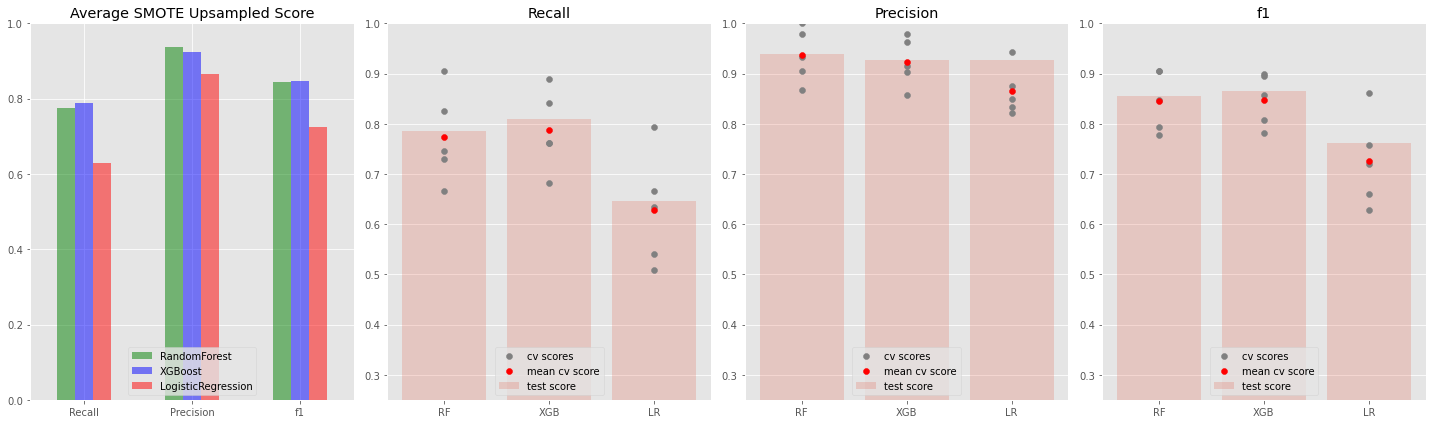

In [6]:
# plot default parameter classifier performance
fig = sm.plot_all_metrics(clf_lst, classifiers)
fig.savefig("../images/default_clf_scores.png")

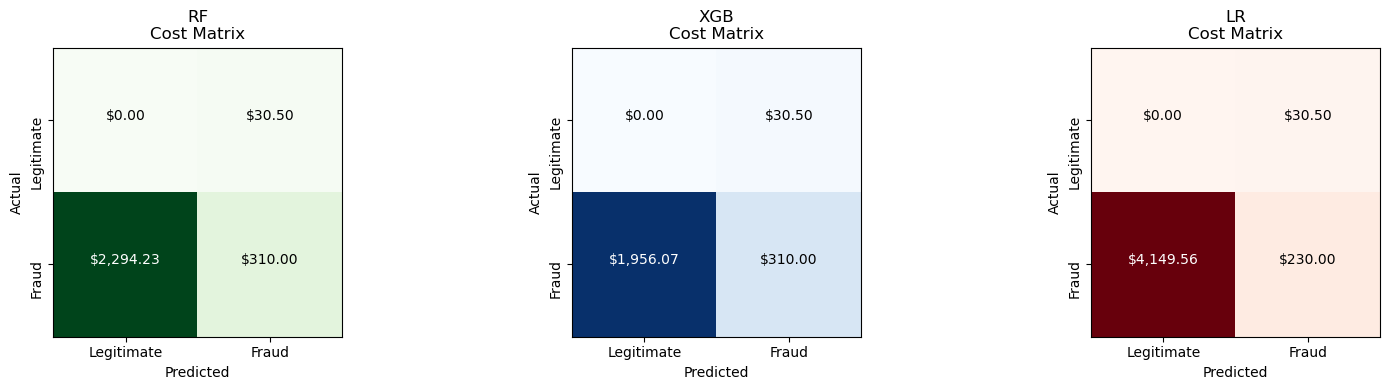

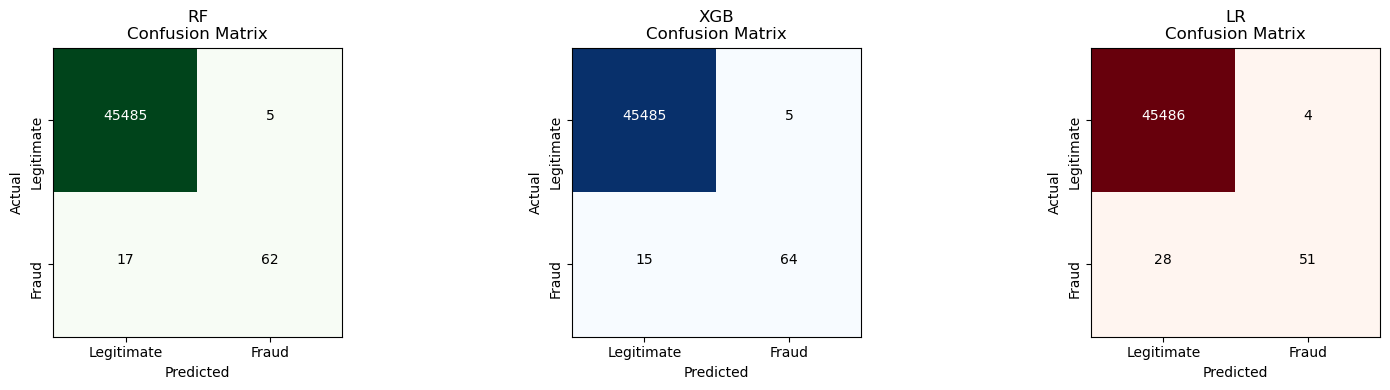

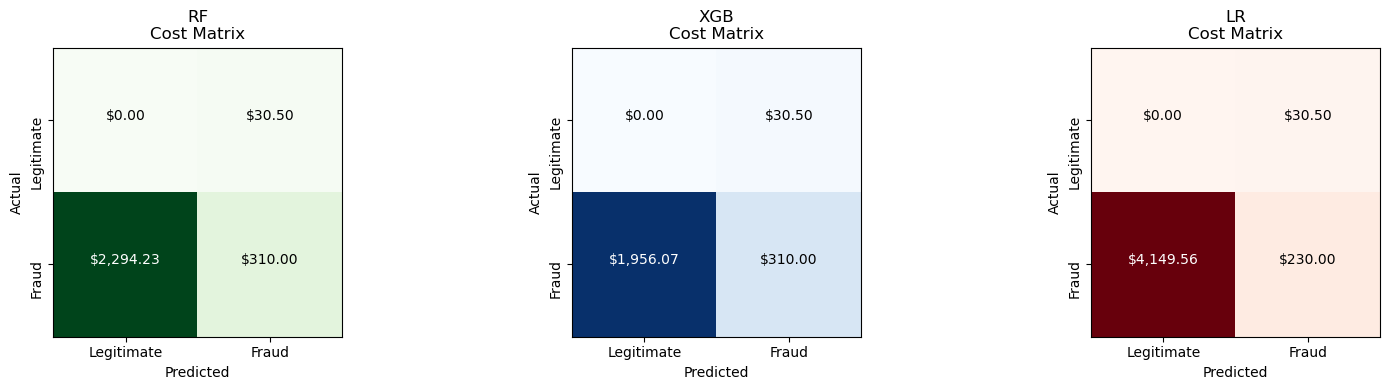

In [7]:
# show the dollar costs for default model
cost_matrix = sc.partial_review(c_test, ReviewCost, ChargebackFee)
sc.class_probabilities(clf_lst, classifiers, X_test, y_test, cost_matrix=cost_matrix)
sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=False)
sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=True)

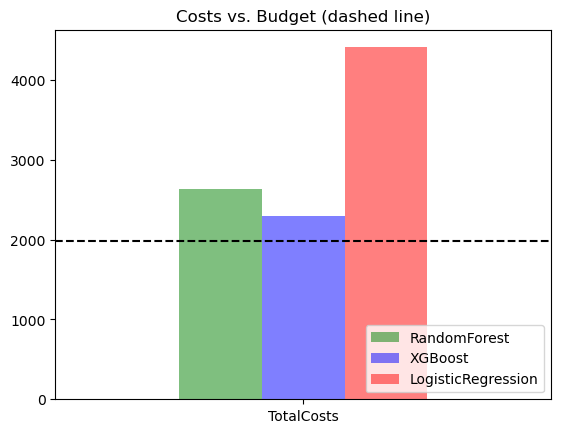

In [8]:
# show the cost% for default model
fig, ax = plt.subplots()
sc.plot_total_cost(ax, clf_lst, classifiers, c_test, y_test)

In [9]:
# Add smote analysis - skip the cv for now since have the plot
classifiers = st.add_smote_classifiers_to_dict(clf_lst, classifiers)
classifiers['LR_smote']['SMOTE_bestparm'] = 0.2
classifiers['RF_smote']['SMOTE_bestparm'] = 0.04
classifiers['XGB_smote']['SMOTE_bestparm'] = 0.15

In [10]:
# Save Version
# h.save_classifier_dict(classifiers, "21")

# load from save classifiers version
classifiers = h.load_classifier_dict("classifiers_ver21.pickle")
clf_lst = ['LR_smote','RF_smote','XGB_smote']

In [11]:
# Fit the training data with smote and run the full metrics
# clf_lst = ['LR_smote','RF_smote','XGB_smote']
# classifiers = st.update_pipeline(clf_lst, classifiers)
# classifiers = sm.fit_classifiers(clf_lst, classifiers, X_train, y_train, SMOTE=True, TimeIt=True)


In [12]:
classifiers = sm.score_classifiers(clf_lst, classifiers, X_test, y_test)

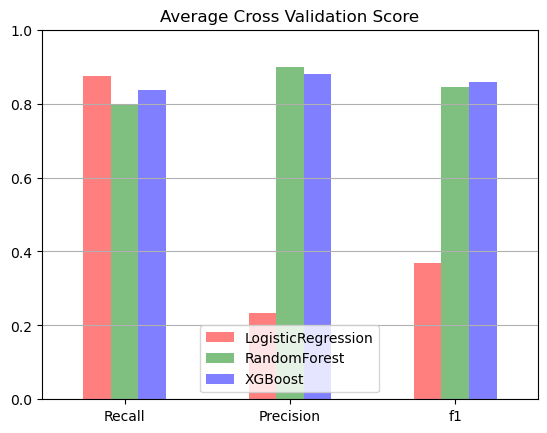

In [13]:
fig, ax = plt.subplots()
sm.plot_clf_metrics(ax, clf_lst, classifiers, score_type="test")

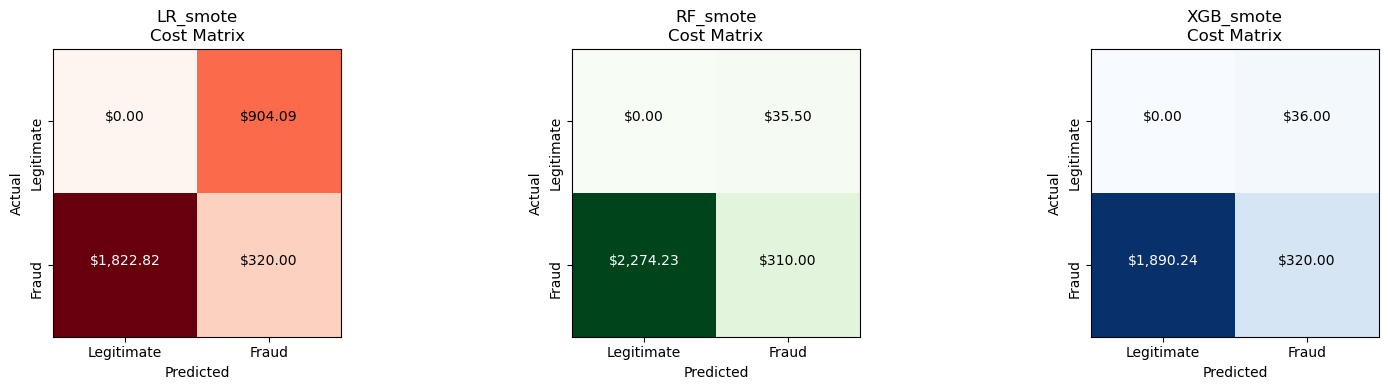

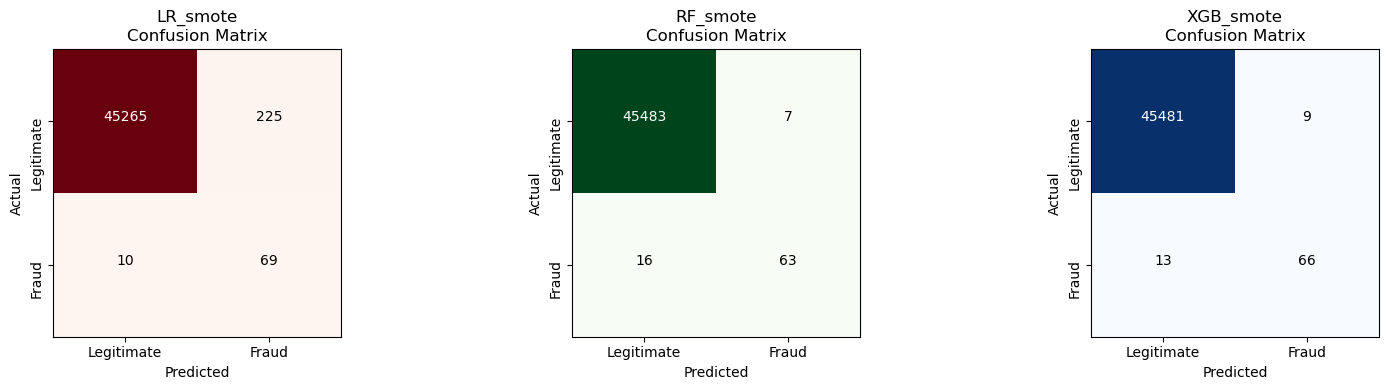

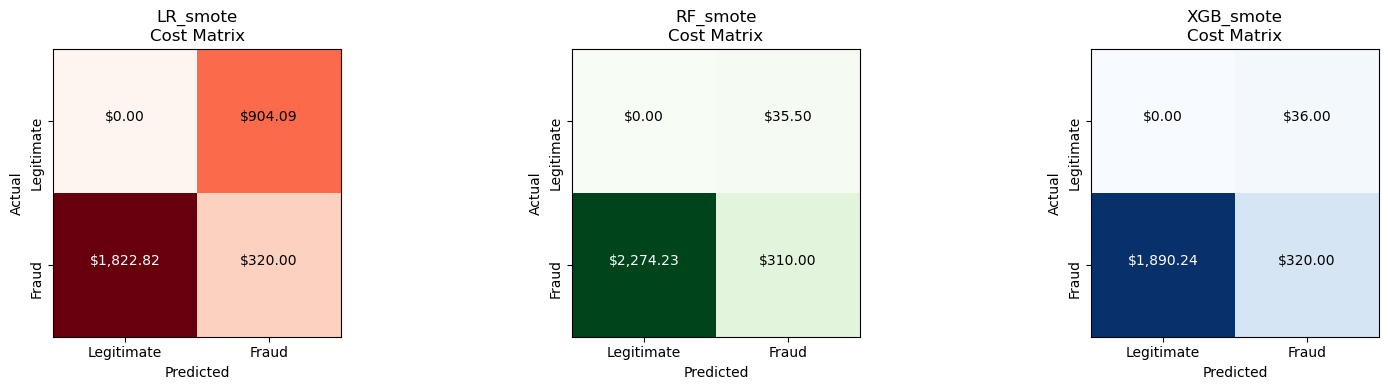

In [14]:
# show the dollar costs for SMOTE upsampled model
cost_matrix = sc.partial_review(c_test, ReviewCost, ChargebackFee)
sc.class_probabilities(clf_lst, classifiers, X_test, y_test, cost_matrix=cost_matrix)
sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=False)
sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=True)

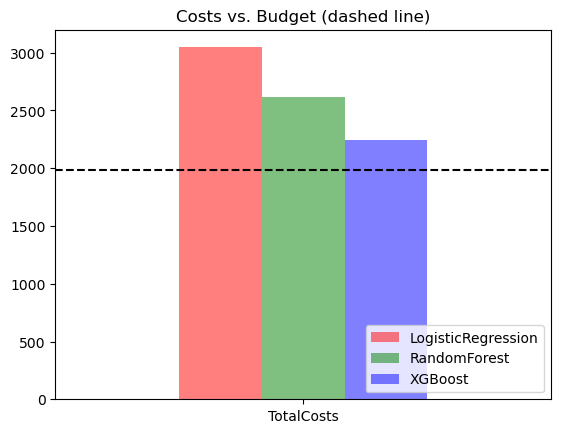

In [15]:
# show the cost% for SMOTE upsampled model
fig, ax = plt.subplots()
sc.plot_total_cost(ax, clf_lst, classifiers, c_test, y_test)

In [16]:
# add the ensemble
classifiers = sm.create_voting_classifier(clf_lst, classifiers, X_train, y_train)

131 seconds cross_validate execution time for Voting classifier


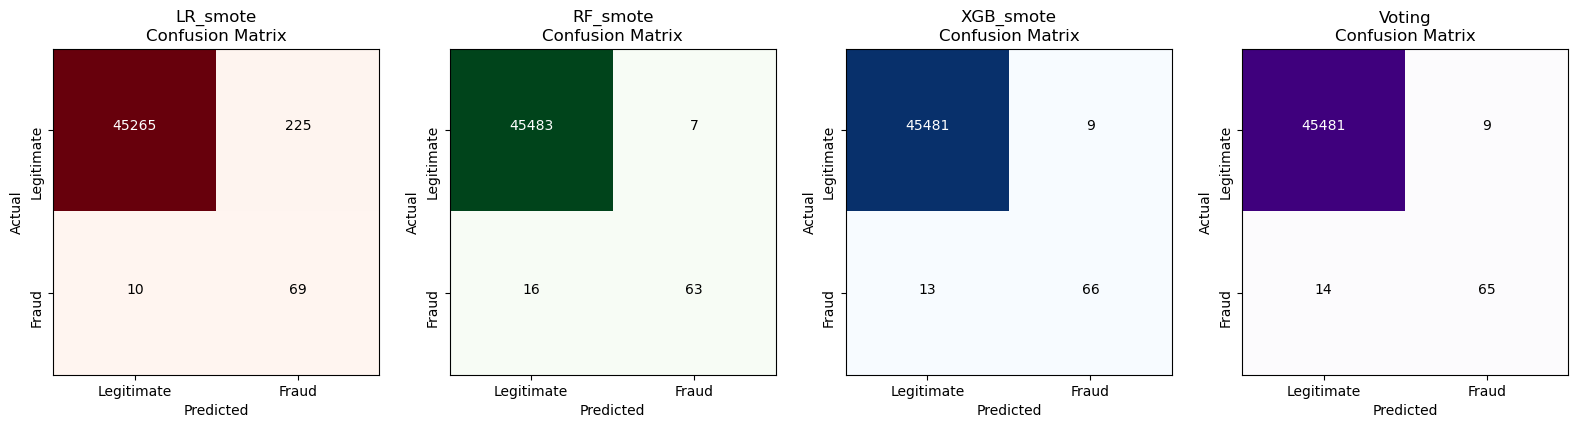

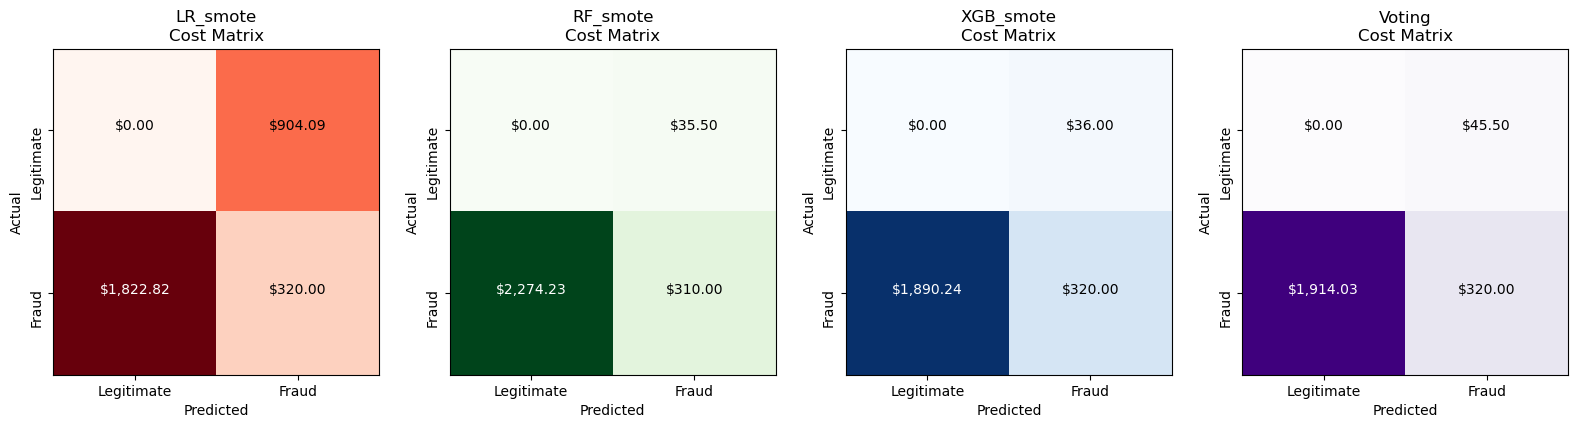

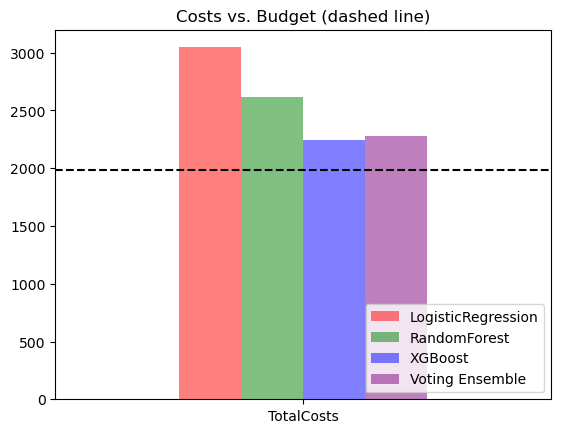

In [17]:
clf_lst = ['LR_smote', 'RF_smote', 'XGB_smote', 'Voting']
# show the dollar costs for SMOTE upsampled model
cost_matrix = sc.partial_review(c_test, ReviewCost, ChargebackFee)
sc.class_probabilities(clf_lst, classifiers, X_test, y_test, cost_matrix=cost_matrix)
fig10 = sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=False)
fig20 = sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=True)
fig10.savefig("../images/test_confusion_matrix.png")
fig20.savefig("../images/test_confusion_matrix_cost.png")

fig, ax = plt.subplots()
sc.plot_total_cost(ax, clf_lst, classifiers, c_test, y_test)
fig.savefig("../images/test_total_cost.png")

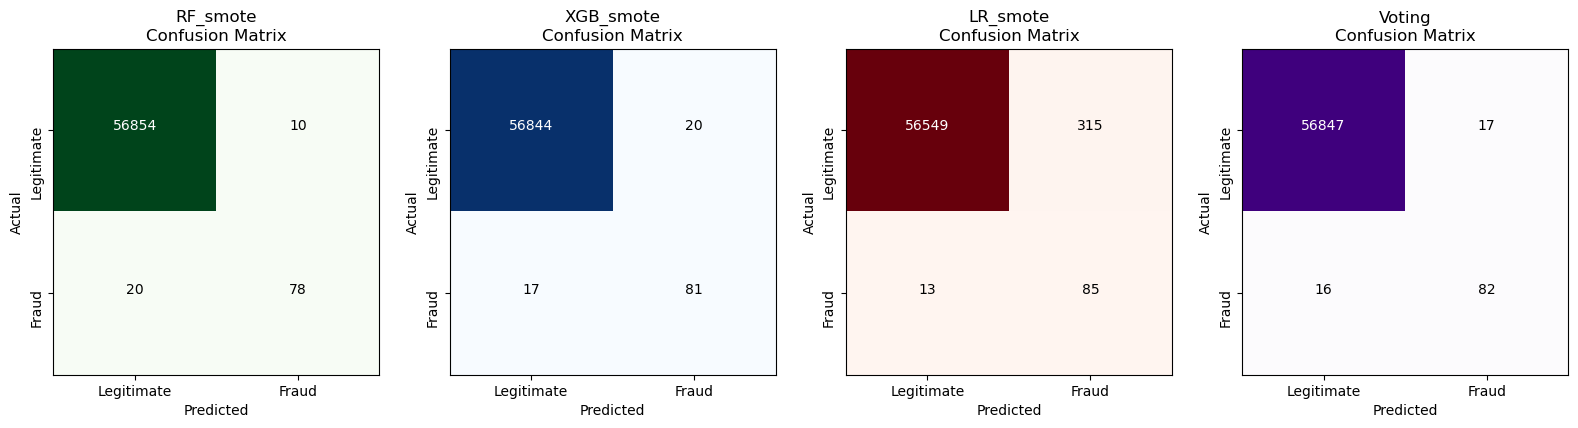

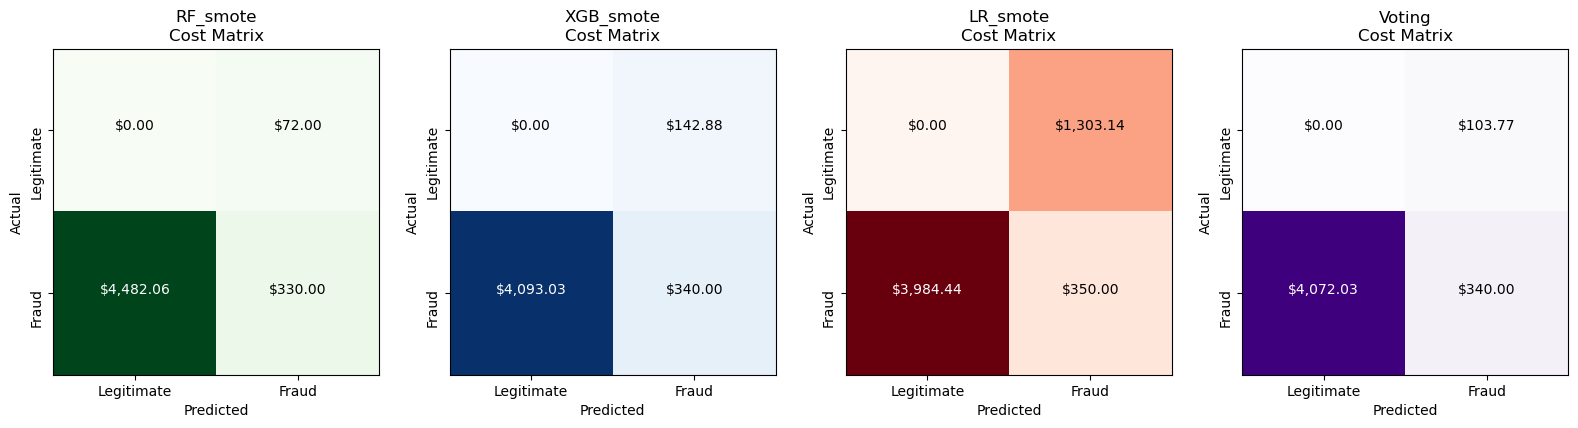

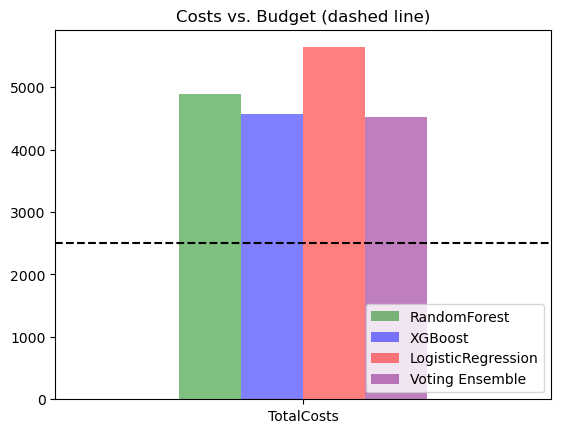

In [18]:
# Try on holdout data
clf_lst = ['RF_smote','XGB_smote','LR_smote', 'Voting']
# show the dollar costs for SMOTE upsampled model
cost_matrix = sc.partial_review(c_holdout, ReviewCost, ChargebackFee)
sc.class_probabilities(clf_lst, classifiers, X_holdout, y_holdout, cost_matrix=cost_matrix)
fig30 = sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=False)
fig40 = sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=True)
fig10.savefig("../images/prod_confusion_matrix.png")
fig20.savefig("../images/prod_confusion_matrix_cost.png")

fig, ax = plt.subplots()
sc.plot_total_cost(ax, clf_lst, classifiers, c_holdout, y_holdout)
fig.savefig("../images/prod_total_cost.png")

In [19]:
h.save_classifier_dict(classifiers, "22")

In [20]:
# Make function for indivisual plot and then you can call it over and over
def Plot_PR_Curve(k, X, y):
    '''
    Calculates and Plots PR Curve and puts threshold marker on curve.
    '''
    # get points to plot on the PR Curve
    classifiers[k]["precision"], classifiers[k]["recall"], classifiers[k]["thresholds"] = \
    precision_recall_curve(y, classifiers[k]["pred_prob"]) 
        
    # find the index of the record with closest threshold to desired threshold value
    classifiers[k]["threshold_idx"] = np.argmin(np.abs(classifiers[k]["thresholds"]-classifiers[k]["threshold"]))
    
    plt.plot(classifiers[k]["precision"], classifiers[k]["recall"], c=classifiers[k]["c"], label=k)
    plt.plot(classifiers[k]["precision"][classifiers[k]["threshold_idx"]], 
             classifiers[k]["recall"][classifiers[k]["threshold_idx"]], 'o', 
             markersize=10, fillstyle='full', 
             label="{:.2f} threshold".format(classifiers[k]["threshold"]), 
             c=classifiers[k]["c"], mew=2)

    plt.legend(loc='center', frameon=False)
    plt.title('Precision-Recall Curve Comparison')    
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim(xmin=-0.05,xmax=1.05);
    plt.ylim(ymin=-0.05,ymax=1.05);


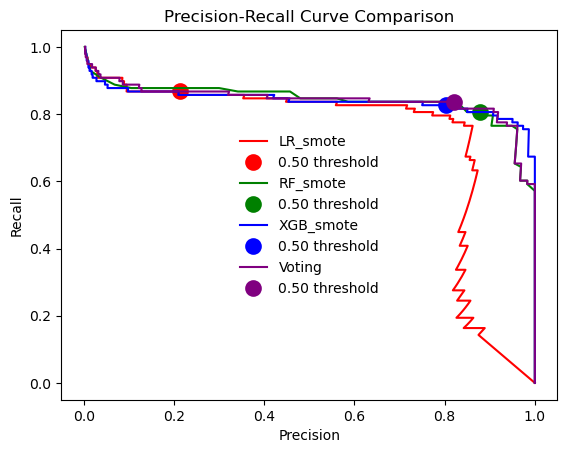

In [25]:
from sklearn.metrics import precision_recall_curve
import numpy as np

clf_lst = ['LR_smote','RF_smote','XGB_smote', 'Voting']
# clf_lst = ['LR','RF','XGB','Voting']
for k in clf_lst:
    Plot_PR_Curve(k, X_holdout, y_holdout)
fig.savefig("../images/pr_curve.png")

In [ ]:
# import numpy as np

# # can try training on the entire non-holdout set
# clf_lst = ['LR_smote','RF_smote','XGB_smote']

# # # merge the test and train data for final project fit
# X = np.concatenate((X_train, X_test), axis=0)
# y = np.concatenate((y_train, y_test), axis=0)
# classifiers = sm.fit_classifiers(clf_lst, classifiers, X, y, SMOTE=True, TimeIt=True)
# classifiers = sm.score_classifiers(clf_lst, classifiers, X_test, y_test)

In [ ]:
# # show the dollar costs for SMOTE upsampled model on final 
# cost_matrix = sc.partial_review(c_holdout, ReviewCost, ChargebackFee)
# sc.class_probabilities(clf_lst, classifiers, X_holdout, y_holdout, cost_matrix=cost_matrix)
# sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=False)
# sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=True)
# fig, ax = plt.subplots()
# sc.plot_total_cost(ax, clf_lst, classifiers, c_holdout, y_holdout)

In [ ]:
# # add the ensemble
# classifiers = sm.create_voting_classifier(clf_lst, classifiers, X, y)

In [ ]:
# clf_lst = ['RF_smote','XGB_smote','LR_smote', 'Voting']
# # show the dollar costs for SMOTE upsampled model
# cost_matrix = sc.partial_review(c_test, ReviewCost, ChargebackFee)
# sc.class_probabilities(clf_lst, classifiers, X_test, y_test, cost_matrix=cost_matrix)
# sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=False)
# sc.plot_multiple_confusion_matrix(clf_lst, classifiers, CostSensitive=True)
# fig, ax = plt.subplots()
# sc.plot_total_cost(ax, clf_lst, classifiers, c_test, y_test)

In [ ]:
# might have to create and train the voting classifier separately to fix error above

to do
- add cost matrix diagram
- add pca plot
- add recall-precision plot
- add thesholding - maybe? - YES!!!!!
- tune the random forest **
- study up on the XGB
- wont get to this but could do an isolation forest